In [12]:
# import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial,freesans'

from astropy.coordinates import SkyCoord
import numpy as np
import pandas as pd
import pathlib
import astropy.coordinates
from astropy.coordinates import AltAz, FK5, Galactic
import astropy.units as u
import astropy.time
import astropy.constants as c
import xarray as xr
import pickle
import time
import os
import sys
import multiprocessing
import necstdb
sys.path.append('/home/amigos/otf_yamada/_python_modules/analy_n2data/script')
#sys.path.append("/home/amigos/git/analy_n2data/script")
#import coordinate_calc
import kisa_rev
from datetime import datetime
from tqdm import tqdm

In [13]:
path = '/mnt/usbdisk9/data/observation/otf/otf_2019/n20200320193251_12CO_2-1_otf_OriKL'
path = '/mnt/usbdisk9/data/observation/otf/otf_2019/n20200320011353_12CO_2-1_otf_OriKL'
#path = "/home/amigos/seigyo/hdd2/copy_HDD4_201912/otf_2019/n20191218021902_12CO_2-1_otf_OriKL/"

In [14]:
xFFTS_Data_topics = [
    
    'xffts_board01',
    'xffts_board02',
    'xffts_board03',
    'xffts_board04',
    'xffts_board05',
    'xffts_board06',
    'xffts_board07',
    'xffts_board08',
    'xffts_board09',
    'xffts_board10',
    'xffts_board11',
    'xffts_board12',
    'xffts_board13',
    'xffts_board14',
    'xffts_board15',
    'xffts_board16'
    
]

In [6]:
def get_array(path, xFFTS_Data_topics):
    db = necstdb.opendb(path)
    xFFTS_data = db.open_table('xffts_board01').read(astype='array')
    obsmode =  db.open_table('obsmode').read(astype='array')
    enc =  db.open_table('status_encoder').read(astype='array')
    
    spec_array = xr.DataArray(

        xFFTS_data['spec'], 
        dims=['t', 'spectral_data'], 
        coords={'t':xFFTS_data['received_time']}
    )


    obsmode_array = xr.DataArray(

        obsmode['obs_mode'],
        dims = ['t'],
        coords={'t':obsmode['received_time'], 'scan_num':('t', obsmode['scan_num'])}


    )
    
    az_array = xr.DataArray(
        
        enc['enc_az']/3600, 
        dims=['t'],
        coords={'t':enc['timestamp']}
    )
    
    el_array = xr.DataArray(
        
        enc['enc_el']/3600, 
        dims=['t'],
        coords={'t':enc['timestamp']}
    )

    return spec_array, obsmode_array, az_array, el_array

def concatenate(spec_array, obsmode_array, az_array, el_array):
    
    reindexed_obsmode_array = obsmode_array.reindex(t=spec_array['t'], method='backfill')
    reindexed_encoder_az_array = az_array.interp_like(spec_array)
    reindexed_encoder_el_array = el_array.interp_like(spec_array)
    
    del obsmode_array
    del az_array
    del el_array
    raw_array = xr.DataArray(
        np.array(spec_array),
        dims=['t', 'spectral_data'],
        coords={'t':spec_array['t'],
                
               'obsmode':('t',np.array(reindexed_obsmode_array)),
               'scan_num':('t', np.array(reindexed_obsmode_array['scan_num'])),
               'azlist':('t', np.array(reindexed_encoder_az_array)),
               'ellist':('t', np.array(reindexed_encoder_el_array))
                
               }
    )
    
    return raw_array

def get_lb(raw_array, time, location):
    AltAzcoordiantes = astropy.coordinates.SkyCoord(
        
        az=raw_array['azlist'], 
        alt=raw_array['ellist'], 
        frame='altaz', 
        obstime=time,
        location=location, 
        unit='deg')
    
    l_list = AltAzcoordiantes.transform_to(Galactic).l
    b_list = AltAzcoordiantes.transform_to(Galactic).b
    return l_list, b_list

def make_data_array(raw_array, l_list, b_list, filename='hogehoge', save=False):
    data_array = xr.DataArray(
        np.array(raw_array), 
        dims=['t', 'spectral_data'],
        coords={'t':raw_array['t'],
               'obsmode':('t',np.array(raw_array['obsmode'])),
               'scan_num':('t', np.array(raw_array['scan_num'])),
               'l_list':('t', l_list),
               'b_list':('t', b_list)}
    )
    
    if save == True:
        data_array.to_netcdf(f"/mnt/usbdisk10/analy_n2data/OTF_netcdf/{filename}.cdf")
    return data_array

In [7]:
IF = '01'
spec_array, obsmode_array, az_array, el_array = get_array(path, xFFTS_Data_topics[0])

In [8]:
raw_array = concatenate(spec_array, obsmode_array, az_array, el_array)

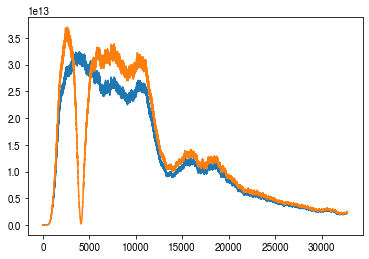

In [9]:
plt.plot(spec_array[200])
plt.plot(spec_array[10000])

In [10]:
# pipline

IF_list = ['01', '02', '03','04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16']

for IF, topic in tqdm(zip(IF_list, xFFTS_Data_topics)):
    print(IF)
    print(topic)
    
    spec_array, obsmode_array, az_array, el_array = get_array(path, topic)
    raw_array = concatenate(spec_array, obsmode_array, az_array, el_array)
    time = [datetime.utcfromtimestamp(i) for i in np.array(raw_array['t'])]

    nanten2 = astropy.coordinates.EarthLocation(
        
            lon =  -67.70308139 * u.deg,
            lat = -22.96995611  * u.deg,
            height = 4863.85 * u.m    
    )

    l_list, b_list = get_lb(raw_array, time=time, location=nanten2)
    
    data_array = make_data_array(
    
    raw_array, 
    l_list,
    b_list, 
    filename=f'n20200320011353_12CO_2-1_otf_OriKL{IF}', 
    save=True
    
    )
    
    del spec_array, obsmode_array, az_array, el_array
    

0it [00:00, ?it/s]

01
xffts_board01


1it [00:45, 45.24s/it]

02
xffts_board02


2it [01:29, 44.81s/it]

03
xffts_board03


3it [02:13, 44.57s/it]

04
xffts_board04


4it [02:58, 44.88s/it]

05
xffts_board05


5it [03:43, 44.82s/it]

06
xffts_board06


6it [04:27, 44.62s/it]

07
xffts_board07


7it [05:11, 44.44s/it]

08
xffts_board08


8it [05:57, 44.91s/it]

09
xffts_board09


9it [06:44, 45.42s/it]

10
xffts_board10


10it [07:33, 46.55s/it]

11
xffts_board11


11it [08:20, 46.64s/it]

12
xffts_board12


12it [09:07, 46.70s/it]

13
xffts_board13


13it [09:57, 47.87s/it]

14
xffts_board14


14it [10:49, 48.95s/it]

15
xffts_board15


15it [11:36, 48.55s/it]

16
xffts_board16


16it [12:23, 46.47s/it]


In [33]:
time = [datetime.utcfromtimestamp(i) for i in np.array(raw_array['t'])]

nanten2 = astropy.coordinates.EarthLocation(
        lon =  -67.70308139 * u.deg,
        lat = -22.96995611  * u.deg,
        height = 4863.85 * u.m
    )

In [34]:
l_list, b_list = get_lb(raw_array, time=time, location=nanten2)

In [11]:
data_array = make_data_array(
    
    raw_array, 
    l_list,
    b_list, 
    filename=f'n20200320193251_12CO_2-1_otf_OriKL_IF{IF}', 
    save=True
    
)

In [40]:
data_array

<xarray.DataArray (t: 20934, spectral_data: 32768)>
array([[1.2836528e+10, 1.2836528e+10, 1.2836528e+10, ..., 2.0689477e+12,
        2.1351196e+12, 2.1391624e+12],
       [1.2631030e+10, 1.2631030e+10, 1.2631030e+10, ..., 2.1529649e+12,
        2.1317448e+12, 2.2218458e+12],
       [1.2766928e+10, 1.2766928e+10, 1.2766928e+10, ..., 2.1252916e+12,
        2.1591129e+12, 2.1334309e+12],
       ...,
       [1.3100738e+10, 1.3100738e+10, 1.3100738e+10, ..., 2.0208622e+12,
        2.0203192e+12, 2.0419649e+12],
       [1.2744699e+10, 1.2744699e+10, 1.2744699e+10, ..., 2.0645874e+12,
        1.9841526e+12, 2.0030236e+12],
       [1.3087892e+10, 1.3087892e+10, 1.3087892e+10, ..., 1.9918843e+12,
        2.0448307e+12, 1.9550284e+12]], dtype=float32)
Coordinates:
  * t         (t) float64 1.585e+09 1.585e+09 1.585e+09 ... 1.585e+09 1.585e+09
    obsmode   (t) |S12 b'          ' b'          ' ... b'          '
    scan_num  (t) float32 61.0 61.0 61.0 61.0 61.0 ... 121.0 121.0 121.0 121.0
    l_list    (t) float64 209.5 209.5 209.5 209.5 ... 209.0 209.0 209.0 209.0
    b_list    (t) float64 -13.25 -13.25 -13.25 -13.25 ... -17.3 -17.3 -17.3
Dimensions without coordinates: spectral_data

In [38]:
l = np.array(data_array['l_list'])
b = np.array(data_array['b_list'])

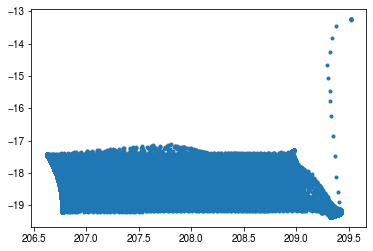

In [39]:
plt.plot(l, b, '.')